# DynamoDB for Clinical Trial Data

## Import necessary libs

In [1]:
import json
import pandas as pd
import boto3
from boto3.dynamodb.conditions import Key
from time import gmtime, strftime
from creds import *
import random
from datetime import date

## Wrap the Dynamo Querying Function

In [64]:
def query_dynamo(domain,studyid):
    global df2
    if studyid == "all":
        response = table.query(
        KeyConditionExpression=Key('domain').eq(str(domain))
        )

        item = response['Items']
        df2 = pd.json_normalize(item,sep='')
        df2 = df2.drop(['domain'], axis=1)
    else:
        response = table.query(
        KeyConditionExpression=Key('domain').eq(str(domain)) & Key('studyid_subjid').begins_with(str(studyid))
        )

        item = response['Items']
        df2 = pd.json_normalize(item,sep='')
        df2 = df2.drop(['studyid_subjid', 'domain'], axis=1)
    return df2



## Connect to your AWS Account

In [41]:
dynamodb = boto3.resource(
    'dynamodb',
    aws_access_key_id=aws_access_key,
    aws_secret_access_key=aws_secret_key,
    region_name = 'us-west-2'
    )

client = boto3.client(
    'dynamodb',
    aws_access_key_id=aws_access_key,
    aws_secret_access_key=aws_secret_key,
    region_name = 'us-west-2'
    )

## Create your table with ADaM Domain and StudyID_Subjid Combination primary key/sort key

In [ ]:
try:     
    table = dynamodb.create_table(
        TableName='clin_test2',
        KeySchema=[
            {
                'AttributeName': 'domain',
                'KeyType': 'HASH'
            },
            {
                'AttributeName': 'studyid_subjid',
                'KeyType': 'RANGE'
            },
        ],
        AttributeDefinitions=[
            {
                'AttributeName': 'domain',
                'AttributeType': 'S'
            },
            {
                'AttributeName': 'studyid_subjid',
                'AttributeType': 'S'
            },
        ],
        ProvisionedThroughput={
            'ReadCapacityUnits': 5,
            'WriteCapacityUnits': 5
        }
    )
    print("Table created successfully")
except Exception as e:
    print("Table not created")
    print(e)

## Insert some mock ADLB data into Study1 and domain ADLB

In [59]:
table = dynamodb.Table('clin_test2')
TRT01A = ["Pembrolizumab","Placebo"]
VISITS = ["VISIT 1","VISIT 2","VISIT 3"]
ABLFL = ["Y","N"]
with table.batch_writer() as batch:
    for i in range(8000,8005):
        aval = random.randrange(0,100)
        batch.put_item(
            Item={
                'domain': 'adlb',
                'studyid_subjid': 'study1'+'_'+str(i),
                'USUBJID': str(i),
                'ABLFL': random.choices(ABLFL,k=1)[0],
                'AVISIT': random.choices(VISITS,k=1)[0],
                'TRT01A': random.choices(TRT01A,k=1)[0],
                'PARAMLBL': {"1" : "Alkaline Phosphatase (IU/L)",
                             "2" : "Aspartate Aminotransferase (IU/L)",
                             "3" : "Alanine Aminotransferase (IU/L)" },
                'AVAL': {"1" : random.randrange(0,100),
                             "2" : random.randrange(0,100),
                             "3" : random.randrange(0,100)}
            }
        )

## Return the results as a pandas flattened data frame

In [65]:
query_dynamo("adlb","study1").head()

,AVISIT,ABLFL,USUBJID,TRT01A,PARAMLBL1,PARAMLBL2,PARAMLBL3,AVAL1,AVAL2,AVAL3
0,VISIT 2,Y,8000,Placebo,Alkaline Phosphatase (IU/L),Aspartate Aminotransferase (IU/L),Alanine Aminotransferase (IU/L),9,44,26
1,VISIT 2,N,8001,Placebo,Alkaline Phosphatase (IU/L),Aspartate Aminotransferase (IU/L),Alanine Aminotransferase (IU/L),63,48,85
2,VISIT 1,Y,8002,Placebo,Alkaline Phosphatase (IU/L),Aspartate Aminotransferase (IU/L),Alanine Aminotransferase (IU/L),58,54,49
3,VISIT 1,N,8003,Pembrolizumab,Alkaline Phosphatase (IU/L),Aspartate Aminotransferase (IU/L),Alanine Aminotransferase (IU/L),84,73,77
4,VISIT 2,N,8004,Pembrolizumab,Alkaline Phosphatase (IU/L),Aspartate Aminotransferase (IU/L),Alanine Aminotransferase (IU/L),13,35,51


## Update table by adding new lab test and results to the first 5 subjects in Study1

In [67]:
for i in range(8000,8005):
    resp = table.update_item(
        Key={"domain": "adlb", "studyid_subjid": 'study1'+'_'+str(i)},
        ExpressionAttributeNames={
            "#paramlbl": "PARAMLBL",
            "#4": "4",
        },
        ExpressionAttributeValues={
            ":lbid": "Gamma-Glutamyl Transferase (IU/L)",
        },
        UpdateExpression="SET #paramlbl.#4 = :lbid",
    )
    
    resp2 = table.update_item(
        Key={"domain": "adlb", "studyid_subjid": 'study1'+'_'+str(i)},
        ExpressionAttributeNames={
            "#aval": "AVAL",
            "#4": "4",
        },
        ExpressionAttributeValues={
            ":avalid": random.randrange(0,100),
        },
        UpdateExpression="SET #aval.#4 = :avalid",
    )

## Observe the updated results as new rows 

### (no new row created in DynamoDB, only set addition of items in JSON)

In [68]:
query_dynamo("adlb","study1")

,AVISIT,ABLFL,USUBJID,TRT01A,PARAMLBL1,PARAMLBL2,PARAMLBL3,PARAMLBL4,AVAL1,AVAL2,AVAL3,AVAL4
0,VISIT 2,Y,8000,Placebo,Alkaline Phosphatase (IU/L),Aspartate Aminotransferase (IU/L),Alanine Aminotransferase (IU/L),Gamma-Glutamyl Transferase (IU/L),9,44,26,6
1,VISIT 2,N,8001,Placebo,Alkaline Phosphatase (IU/L),Aspartate Aminotransferase (IU/L),Alanine Aminotransferase (IU/L),Gamma-Glutamyl Transferase (IU/L),63,48,85,21
2,VISIT 1,Y,8002,Placebo,Alkaline Phosphatase (IU/L),Aspartate Aminotransferase (IU/L),Alanine Aminotransferase (IU/L),Gamma-Glutamyl Transferase (IU/L),58,54,49,11
3,VISIT 1,N,8003,Pembrolizumab,Alkaline Phosphatase (IU/L),Aspartate Aminotransferase (IU/L),Alanine Aminotransferase (IU/L),Gamma-Glutamyl Transferase (IU/L),84,73,77,20
4,VISIT 2,N,8004,Pembrolizumab,Alkaline Phosphatase (IU/L),Aspartate Aminotransferase (IU/L),Alanine Aminotransferase (IU/L),Gamma-Glutamyl Transferase (IU/L),13,35,51,19
5,VISIT 2,Y,8005,Placebo,Alkaline Phosphatase (IU/L),Aspartate Aminotransferase (IU/L),Alanine Aminotransferase (IU/L),NaN,19,68,29,NaN
6,VISIT 1,N,8006,Placebo,Alkaline Phosphatase (IU/L),Aspartate Aminotransferase (IU/L),Alanine Aminotransferase (IU/L),NaN,43,91,2,NaN
7,VISIT 1,Y,8007,Placebo,Alkaline Phosphatase (IU/L),Aspartate Aminotransferase (IU/L),Alanine Aminotransferase (IU/L),NaN,85,99,64,NaN
8,VISIT 1,N,8008,Pembrolizumab,Alkaline Phosphatase (IU/L),Aspartate Aminotransferase (IU/L),Alanine Aminotransferase (IU/L),NaN,8,57,15,NaN
9,VISIT 2,N,8009,Pembrolizumab,Alkaline Phosphatase (IU/L),Aspartate Aminotransferase (IU/L),Alanine Aminotransferase (IU/L),NaN,32,88,81,NaN


## Plot data in Seaborn

<AxesSubplot:title={'center':'Alkaline Phosphatase (IU/L)'}, xlabel='TRT01A', ylabel='AVAL1'>

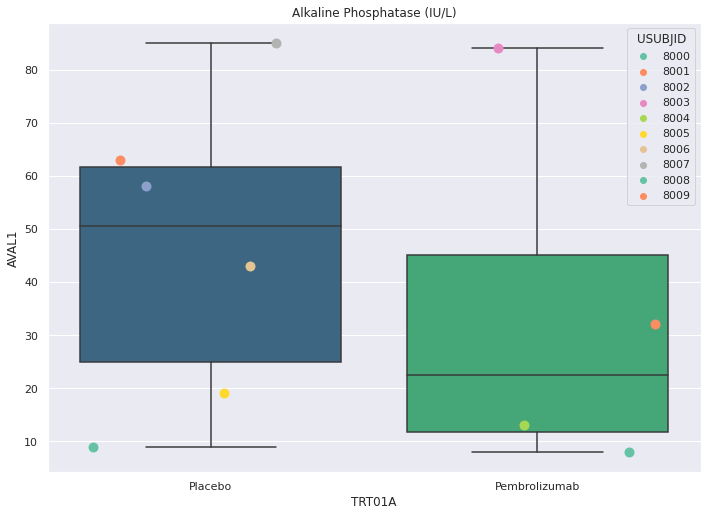

In [94]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
data = query_dynamo("adlb","study1")
data['AVAL1'] = data['AVAL1'].astype('float')
sns.boxplot(data=data, 
            x="TRT01A", 
            y="AVAL1",
            orient="v",
            palette = 'viridis').set(title=data['PARAMLBL1'][0])
sns.stripplot(x='TRT01A', 
              y='AVAL1', 
              hue='USUBJID',
              jitter=True,
              dodge=True, 
              marker='o', 
              palette="Set2",
              alpha=1,
              data=data,
              size=10)